# OLED Optimization with FourierFields


In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

from meep.materials import Ag as Ag

mp.verbosity(0)

SiO2 = mp.Medium(epsilon=2.13)    # 글래스의 굴절률 설정
GaN = mp.Medium(epsilon=6.18)   # OLED 유기층의 굴절률 설정
Al2O3 = mp.Medium(epsilon=3.17)    # 실리콘 질화물의 굴절률 설정
Air = mp.Medium(epsilon=1.0)    # 공기의 굴절률 설정

Basic setup

In [2]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.8       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 1/(0.45) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 25             # 추출할 주파수 개수
design_region_resolution = 50                                                             

tSiO2 = 0.07    # passivation layer 두께
tAL = 1    # oxide side 두께
tAg = 0.07    # 은 층 두께
tGaN = 1   # GaN 층 두께
tPML = 0.1    # PML 두께
MtoPML = 0.1
MtoD = 0.5

L = 1.0       # OLED의 가로/세로 길이

design_region_width = L + 2*tSiO2
design_region_height = 0.1

Sy = tPML + MtoPML + MtoD + design_region_height + tGaN + tAg   # Z 방향 전체 길이
Sx = L + 2*tSiO2 + + 2*tAL + 2*tPML                        # X/Y 방향 길이
cell_size = mp.Vector3(Sx, Sy)    # 시뮬레이션 셀 크기

boundary_layers = [mp.Absorber(0.1,direction=mp.X),
                   mp.PML(0.1,direction=mp.Y,side=mp.High)]

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1
structure_weights = np.loadtxt(f'lastdesign.txt')
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), Air, SiO2, grid_type="U_MEAN")
design_variables.update_weights(structure_weights)
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(y=0.5*Sy - tPML - MtoPML - MtoD - 0.5*design_region_height),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    mp.Block(material=design_variables,      # 디자인 영역
             size=design_region.size,
             center=design_region.center),
    
    mp.Block(material=GaN,      # GaN 층
             size=mp.Vector3(L, tGaN),
             center=mp.Vector3(y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*tGaN)),
    
    mp.Block(material=Ag,                       # 은 층
             size=mp.Vector3(L, tAg),
             center=mp.Vector3(y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - tGaN - 0.5*tAg)),
    
    mp.Block(material=SiO2,                       # 글래스 층
             size=mp.Vector3(tSiO2, tGaN + tAg),
             center=mp.Vector3(x=0.5*Sx - tPML - tAL - 0.5*tSiO2, y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg) )),

    mp.Block(material=SiO2,                       # 글래스 층
             size=mp.Vector3(tSiO2, tGaN + tAg),
             center=mp.Vector3(x=-0.5*Sx + tPML + tAL + 0.5*tSiO2, y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg))),
    
    mp.Block(material=Al2O3,                       # 알루미늄 층
             size=mp.Vector3(tPML + tAL, tGaN + tAg),
             center=mp.Vector3(x=-0.5*Sx + 0.5*(tPML + tAL), y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg))),

    mp.Block(material=Al2O3,                       # 알루미늄 층
             size=mp.Vector3(tPML + tAL, tGaN + tAg),
             center=mp.Vector3(x=0.5*Sx - 0.5*(tPML + tAL), y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg))),
]

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = []
src_num = 49

for i in range(src_num):  # x 방향 루프
        sources.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -L/2 + (L)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - MtoPML - MtoD - design_region_height - tGaN + 0.5*tAg,
                    z = 0
                )
            )
        )

sim = []

for i in range(src_num):
    sim.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometry,
                      sources=[sources[i]],
                      extra_materials=[Ag],)
    )
                    

<Axes: xlabel='X', ylabel='Y'>

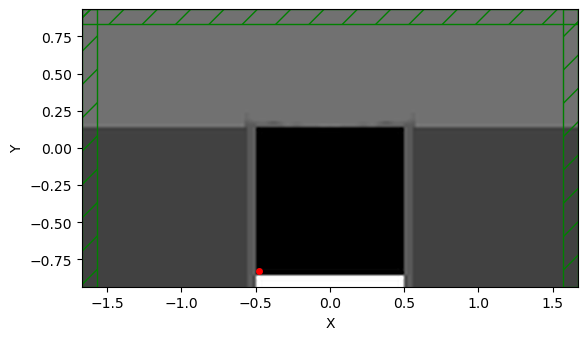

In [3]:
sim[0].plot2D()

In [4]:
monitor_position, monitor_size = mp.Vector3(0,0.5*Sy - tPML - MtoPML), mp.Vector3(Sx - 2*tPML,0)

FourierFields_Ez = []
FourierFields_Hx = []
for i in range(src_num):
    FourierFields_Ez.append(mpa.FourierFields(sim[i],mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True))
    FourierFields_Hx.append(mpa.FourierFields(sim[i],mp.Volume(center=monitor_position,size=monitor_size),mp.Hx,yee_grid=True))
ob_list_Ez = []
ob_list_Hx = []
for i in range(src_num):
    ob_list_Ez.append(FourierFields_Ez[i])
    ob_list_Hx.append(FourierFields_Hx[i])

def J(fields_Ez, fields_Hx):
    return npa.real(npa.sum(fields_Ez[:,:]*(npa.real(fields_Hx[:,:])-npa.imag(fields_Hx[:,:])*1j)))

opt = []
for i in range(src_num):
    opt.append(mpa.OptimizationProblem(
        simulation=sim[i],
        objective_functions=[J],
        objective_arguments=[ob_list_Ez[i], ob_list_Hx[i]],
        design_regions=[design_region],
        frequencies=[fcen],
        maximum_run_time=100,
    ))

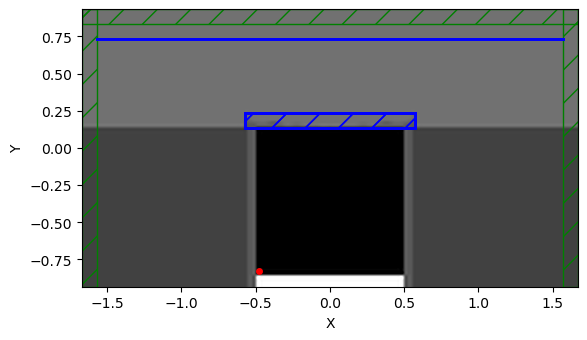

In [5]:
opt[0].plot2D(True)

In [6]:
minimum_length = 0.02  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

In [7]:
def mapping(x, eta, beta):

    # # filter
    # filtered_field = mpa.conic_filter(
    #     x,
    #     filter_radius,
    #     design_region_width,
    #     design_region_height,
    #     design_region_resolution,
    # )

    # # projection
    # projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return x

In [8]:
import os

# 저장 폴더 생성
output_dir = "mode_number"
os.makedirs(output_dir, exist_ok=True)

src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = []

for i in range(src_num):  # x 방향 루프
        source.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -L/2 + (L)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - MtoPML - MtoD - design_region_height - tGaN + 0.5*tAg,
                    z = 0
                )
            )
        )
ppopt = []
Ez_r0 = [0]*src_num
Ez_r1 = [0]*src_num
for i in range(src_num):
    ppopt.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometry,
                      sources=[source[i]],
                      extra_materials=[Ag],)
    )

    ppopt[i].reset_meep()

    ppopt[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometry,
                        sources=[sources[i]],
                        extra_materials=[Ag],)
    
    dft_fields_r0=ppopt[i].sim.add_dft_fields([mp.Ez],fcen,0,1,
                                    center=mp.Vector3(0,0.5*Sy - tPML - MtoPML,0),
                                    size=mp.Vector3(Sx - 2*tPML,0,0),yee_grid=True)
    dft_fields_r1=ppopt[i].sim.add_dft_fields([mp.Ez],fcen,0,1,
                                    center=mp.Vector3(0,0,0),
                                    size=mp.Vector3(Sx,Sy,0),yee_grid=True)

    ppopt[i].sim.run(until=100.0)

    Ez_r0[i]=ppopt[i].sim.get_dft_array(dft_fields_r0,mp.Ez,0)
    Ez_r1[i]=ppopt[i].sim.get_dft_array(dft_fields_r1,mp.Ez,0)

    Ez_comp=Ez_r0[i][:]

    m0ez_fft=npa.fft.fftshift(npa.fft.fft(Ez_comp))/(design_region_width*resolution+1)
    kx = npa.fft.fftshift(np.fft.fftfreq(len(Ez_comp), 1 / resolution))

    plt.plot(kx,np.abs(m0ez_fft),"-ro")
    plt.xlabel(r"Wavevector $k_x$ (2$\pi^{-1}$)")
    plt.grid()
    plt.xlim([-3,3])

    plt.savefig(os.path.join(output_dir, f"mode_number_{i}.png"))
    plt.cla()
    plt.clf()
    plt.close()

    plt.savefig(os.path.join(output_dir, f"mode_number_{i}.png"))
    plt.cla()
    plt.clf()
    plt.close()

    x = np.linspace(-0.5 * Sx + tPML, 0.5 * Sx - tPML, int((Sx- 2*tPML)*resolution+2))
    theta_out = np.arcsin(2 * np.sin(0))  # Snell's Law
    lambda0 = 0.55
    kx_air = (2 * np.pi / lambda0) * np.sin(theta_out)
    Ez_comp = Ez_r0[i][:] * np.exp(-1j * kx_air * x)
    Ez_fft = npa.fft.fftshift(npa.fft.fft(Ez_comp)) / len(Ez_comp)
    kx_axis = npa.fft.fftshift(np.fft.fftfreq(len(Ez_comp), d=1/resolution))
    kx_rad = 2 * np.pi * kx_axis  # [rad/μm]
    sin_theta = kx_rad * lambda0 / (2 * np.pi)  # = sin(θ)
    plt.plot(sin_theta, np.abs(Ez_fft), 'r-o')
    plt.xlabel("sin(theta) (air)")

    plt.savefig(os.path.join(output_dir, f"angle_{i}.png"))
    plt.cla()
    plt.clf()
    plt.close()

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

In [9]:
geometryo = [
    mp.Block(material=GaN,      # GaN 층
             size=mp.Vector3(L, tGaN),
             center=mp.Vector3(y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*tGaN)),
    
    mp.Block(material=Ag,                       # 은 층
             size=mp.Vector3(L, tAg),
             center=mp.Vector3(y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - tGaN - 0.5*tAg)),
    
    mp.Block(material=SiO2,                       # 글래스 층
             size=mp.Vector3(tSiO2, tGaN + tAg),
             center=mp.Vector3(x=0.5*Sx - tPML - tAL - 0.5*tSiO2, y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg) )),

    mp.Block(material=SiO2,                       # 글래스 층
             size=mp.Vector3(tSiO2, tGaN + tAg),
             center=mp.Vector3(x=-0.5*Sx + tPML + tAL + 0.5*tSiO2, y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg))),
    
    mp.Block(material=Al2O3,                       # 알루미늄 층
             size=mp.Vector3(tPML + tAL, tGaN + tAg),
             center=mp.Vector3(x=-0.5*Sx + 0.5*(tPML + tAL), y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg))),

    mp.Block(material=Al2O3,                       # 알루미늄 층
             size=mp.Vector3(tPML + tAL, tGaN + tAg),
             center=mp.Vector3(x=0.5*Sx - 0.5*(tPML + tAL), y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg))),
]

In [10]:
import os

# 저장 폴더 생성
output_dir = "origin_mode_number"
os.makedirs(output_dir, exist_ok=True)

ppopto = []
Ez_r0 = [0]*src_num
Ez_r1 = [0]*src_num
for i in range(src_num):
    ppopto.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometryo,
                      sources=[source[i]],
                      extra_materials=[Ag],)
    )

    ppopto[i].reset_meep()

    ppopto[i].sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometry,
                        sources=[sources[i]],
                        extra_materials=[Ag],)
    
    dft_fields_r0=ppopto[i].sim.add_dft_fields([mp.Ez],fcen,0,1,
                                    center=mp.Vector3(0,0.5*Sy - tPML - MtoPML,0),
                                    size=mp.Vector3(Sx - 2*tPML,0,0),yee_grid=True)
    dft_fields_r1=ppopto[i].sim.add_dft_fields([mp.Ez],fcen,0,1,
                                    center=mp.Vector3(0,0,0),
                                    size=mp.Vector3(Sx,Sy,0),yee_grid=True)

    ppopto[i].sim.run(until=100.0)

    Ez_r0[i]=ppopto[i].sim.get_dft_array(dft_fields_r0,mp.Ez,0)
    Ez_r1[i]=ppopto[i].sim.get_dft_array(dft_fields_r1,mp.Ez,0)

    Ez_comp=Ez_r0[i][:]

    m0ez_fft=npa.fft.fftshift(npa.fft.fft(Ez_comp))/(design_region_width*resolution+1)
    kx = npa.fft.fftshift(np.fft.fftfreq(len(Ez_comp), 1 / resolution))

    plt.plot(kx,np.abs(m0ez_fft),"-ro")
    plt.xlabel(r"Wavevector $k_x$ (2$\pi^{-1}$)")
    plt.grid()
    plt.xlim([-3,3])

    plt.savefig(os.path.join(output_dir, f"mode_number_{i}.png"))
    plt.cla()
    plt.clf()
    plt.close()

    x = np.linspace(-0.5 * Sx + tPML, 0.5 * Sx - tPML, int((Sx- 2*tPML)*resolution+2))
    theta_out = np.arcsin(2 * np.sin(0))  # Snell's Law
    lambda0 = 0.55
    kx_air = (2 * np.pi / lambda0) * np.sin(theta_out)
    Ez_comp = Ez_r0[i][:] * np.exp(-1j * kx_air * x)
    Ez_fft = npa.fft.fftshift(npa.fft.fft(Ez_comp)) / len(Ez_comp)
    kx_axis = npa.fft.fftshift(np.fft.fftfreq(len(Ez_comp), d=1/resolution))
    kx_rad = 2 * np.pi * kx_axis  # [rad/μm]
    sin_theta = kx_rad * lambda0 / (2 * np.pi)  # = sin(θ)
    plt.plot(sin_theta, np.abs(Ez_fft), 'r-o')
    plt.xlabel("sin(theta) (air)")

    plt.savefig(os.path.join(output_dir, f"angle_{i}.png"))
    plt.cla()
    plt.clf()
    plt.close()

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')

FloatProgress(value=0.0, description='0% done ')